In [1]:
# Setup library
## install -r requirements.txt
from __future__ import absolute_import, division, print_function, unicode_literals
import os

import matplotlib.pylab as plt
# %matplotlib widget
%matplotlib inline

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [2]:
# Classifier from TF hub
import numpy as np


classifier_url = 'https://tfhub.dev/google/imagenet/mobilenet_v2_100_96/classification/4'
IMAGE_SHAPE = (96, 96)
classifier = tf.keras.Sequential([
    hub.KerasLayer(classifier_url, input_shape=IMAGE_SHAPE+(3, )) # Channel 3 RGB
])

## And labels
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt', 
                                      'https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

In [3]:
# prepare dataset
dataset_root = os.path.abspath(os.path.expanduser('./img_data/'))
print(f'Dataset root: {dataset_root}')

image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255,
                                                                  validation_split=0.1)
train_data = image_generator.flow_from_directory(dataset_root, target_size=IMAGE_SHAPE,
                                                 subset='training')
validation_data = image_generator.flow_from_directory(dataset_root, target_size=IMAGE_SHAPE,
                                                 subset='validation')

for image_batch, label_batch in validation_data:
    print(f'Image batch shape: {image_batch.shape}')
    print(f'Label batch shape: {label_batch.shape}')
    break

Dataset root: /home/harny/Github/tff-app/img_data
Found 234944 images belonging to 16 classes.
Found 26097 images belonging to 16 classes.
Image batch shape: (32, 96, 96, 3)
Label batch shape: (32, 16)


Batch result shape: (32, 1001)
Batch predicted class names: ['crossword puzzle' 'crossword puzzle' 'strainer' 'jigsaw puzzle'
 'crossword puzzle' 'crossword puzzle' 'crossword puzzle'
 'crossword puzzle' 'jigsaw puzzle' 'crossword puzzle' 'crossword puzzle'
 'crossword puzzle' 'strainer' 'jigsaw puzzle' 'crossword puzzle'
 'crossword puzzle' 'crossword puzzle' 'jigsaw puzzle' 'crossword puzzle'
 'jigsaw puzzle' 'strainer' 'crossword puzzle' 'strainer' 'rule'
 'theater curtain' 'crossword puzzle' 'crossword puzzle' 'strainer'
 'digital clock' 'strainer' 'crossword puzzle' 'crossword puzzle']


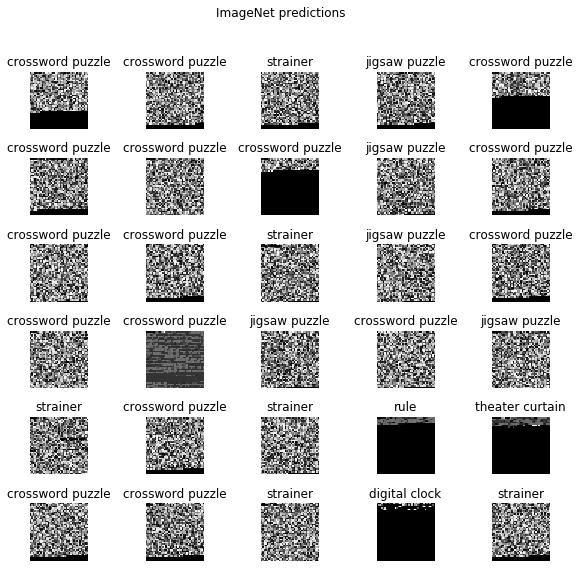

In [4]:
# Predict batch input example
## using original ImangeNet classifier

import PIL.Image as Image

result_batch = classifier.predict(image_batch)
print(f'Batch result shape: {result_batch.shape}')

predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
print(f'Batch predicted class names: {predicted_class_names}')

fig1 = plt.figure(figsize=(10, 9))
fig1.subplots_adjust(hspace=0.5)
for n in range(30):
    ax = fig1.add_subplot(6, 5, n+1)
    ax.imshow(image_batch[n])
    ax.set_title(predicted_class_names[n])
    ax.axis('off')
_ = fig1.suptitle('ImageNet predictions')

In [6]:
# Prepare transfer learning
## Download headless (without the top classification layer) model
feature_extractor_url = 'https://tfhub.dev/google/imagenet/mobilenet_v2_100_96/feature_vector/4'
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=IMAGE_SHAPE+(3, ))
feature_batch = feature_extractor_layer(image_batch)
print(f'Feature vector shape: {feature_batch.shape}')

## Frozen feature extraction layer
feature_extractor_layer.trainable = False # for transfer learning classifier

## Make a model for classification
model = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Dense(train_data.num_classes, activation='softmax')
])

Feature vector shape: (32, 1280)


In [7]:
## Check the model and prediction result
model.summary()

predictions = model(image_batch)
print(f'Prediction shape: {predictions.shape}')

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 16)                20496     
Total params: 2,278,480
Trainable params: 20,496
Non-trainable params: 2,257,984
_________________________________________________________________
Prediction shape: (32, 16)


In [8]:
# Train build
## Compile model for train
base_learning_rate = 0.001 # default
model.compile(
    optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
    loss='categorical_crossentropy',
    metrics=['acc'])

## Log class
### https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/Callback
class CollectBatchStats(tf.keras.callbacks.Callback):
    def __init__(self):
        self.batch_losses = []
        self.batch_val_losses = []
        self.batch_acc = []
        self.batch_val_acc = []

#     def on_train_batch_end(self, batch, logs=None):
#         self.batch_losses.append(logs['loss'])
#         self.batch_acc.append(logs['acc'])
#         self.model.reset_metrics()
    
#     def on_test_batch_end(self, batch, logs=None):
#         self.batch_val_losses.append(logs['loss'])
#         self.batch_val_acc.append(logs['acc'])
#         self.model.reset_metrics()
    
    def on_epoch_end(self, epoch, logs=None):
        self.batch_losses.append(logs['loss'])
        self.batch_acc.append(logs['acc'])
        self.batch_val_losses.append(logs['val_loss'])
        self.batch_val_acc.append(logs['val_acc'])
        self.model.reset_metrics()


steps_per_epoch = np.ceil(train_data.samples/train_data.batch_size) # train all dataset per epoch
initial_epoch = 10
batch_stats_callback = CollectBatchStats()

history = model.fit_generator(train_data,  
                              epochs=initial_epoch,
                              steps_per_epoch=steps_per_epoch,
                              validation_data=validation_data,
                              callbacks=[batch_stats_callback])

Instructions for updating:
Please use Model.fit, which supports generators.


Instructions for updating:
Please use Model.fit, which supports generators.


  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train for 7342.0 steps, validate for 816 steps
Epoch 1/10
7342/7342 [==============================] - 547s 74ms/step - loss: 1.3316 - acc: 0.5408 - val_loss: 1.3754 - val_acc: 0.5212
Epoch 2/10
7342/7342 [==============================] - 544s 74ms/step - loss: 1.2404 - acc: 0.5657 - val_loss: 1.3163 - val_acc: 0.5505
Epoch 3/10
7342/7342 [==============================] - 540s 74ms/step - loss: 1.2157 - acc: 0.5718 - val_loss: 1.2781 - val_acc: 0.5849
Epoch 4/10
7342/7342 [==============================] - 540s 74ms/step - loss: 1.2017 - acc: 0.5760 - val_loss: 1.3097 - val_acc: 0.5856
Epoch 5/10
7342/7342 [==============================] - 539s 73ms/step - loss: 1.1946 - acc: 0.5779 - val_loss: 1.2861 - val_acc: 0.5901
Epoch 6/10
7342/7342 [==============================] - 535s 73ms/step - loss: 1.1864 - acc: 0.5798 - val_loss: 1.3284 - val_acc: 0.5507
Epoch 7/10
7342/7342 [==============================] - 537s 73ms/step - loss: 1.1818 - acc: 0.5815 - val_loss: 1.2989 - val_acc: 0

Text(0.5, 0, 'epoch')

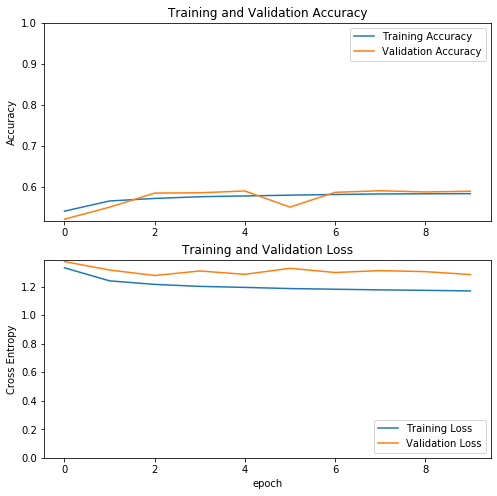

In [12]:
# Draw learning curves chart
acc = batch_stats_callback.batch_acc
val_acc = batch_stats_callback.batch_val_acc
loss = batch_stats_callback.batch_losses
val_loss = batch_stats_callback.batch_val_losses

fig2 = plt.figure(figsize=(8, 8))
ax1 = fig2.add_subplot(2, 1, 1)
ax1.plot(acc, label='Training Accuracy')
ax1.plot(val_acc, label='Validation Accuracy')
ax1.legend(loc='upper right')
ax1.set_ylabel('Accuracy')
ax1.set_ylim([min(ax1.get_ylim()),1])
ax1.set_title('Training and Validation Accuracy')

ax2 = fig2.add_subplot(2, 1, 2)
ax2.plot(loss, label='Training Loss')
ax2.plot(val_loss, label='Validation Loss')
ax2.legend(loc='lower right')
ax2.set_ylabel('Cross Entropy')
ax2.set_ylim([0,max(ax2.get_ylim())])
ax2.set_title('Training and Validation Loss')
ax2.set_xlabel('epoch')

Classes: ['Hek293' 'Hela' 'Pc12']


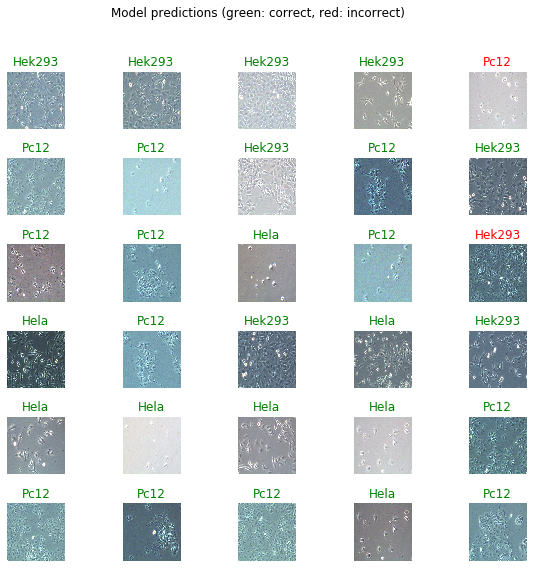

In [9]:
# Plot results
class_names = sorted(validation_data.class_indices.items(), key=lambda pair:pair[1])
class_names = np.array([key.title() for key, value in class_names])
print(f'Classes: {class_names}')

## get result labels
predicted_batch = model.predict(image_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]

label_id = np.argmax(label_batch, axis=-1)

## plot
fig3 = plt.figure(figsize=(10,9))
fig3.subplots_adjust(hspace=0.5)
for n in range(30):
    ax = fig3.add_subplot(6, 5, n+1)
    ax.imshow(image_batch[n])
    color = 'green' if predicted_id[n] == label_id[n] else 'red'
    ax.set_title(predicted_label_batch[n].title(), color=color)
    ax.axis('off')
_ = fig3.suptitle('Model predictions (green: correct, red: incorrect)')

In [10]:
# Export model
import time
t = time.time()

export_path = f'./saved_models/{int(t)}'
model.save(export_path, save_format='tf')

print(f'Export the model to {export_path}')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


INFO:tensorflow:Assets written to: ./saved_models/1580977623/assets


INFO:tensorflow:Assets written to: ./saved_models/1580977623/assets


Export the model to ./saved_models/1580977623


In [11]:
# Check the exported model
reloaded = tf.keras.models.load_model(export_path)

result_batch = model.predict(image_batch)
reloaded_result_batch = reloaded.predict(image_batch)

print(f'Comparison between own model and exported model {abs(reloaded_result_batch - result_batch).max()}')

Comparison between own model and exported model 0.0


In [12]:
## Unfrozen feature extraction layer
feature_extractor_layer.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate/10),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['acc'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 3)                 3843      
Total params: 2,261,827
Trainable params: 2,227,715
Non-trainable params: 34,112
_________________________________________________________________


In [13]:
finetune_epoch = 20

history_fine = model.fit_generator(train_data,
                                   epochs=initial_epoch+finetune_epoch,
                                   initial_epoch=initial_epoch, # == history.epoch[-1]+1
                                   steps_per_epoch=steps_per_epoch,
                                   validation_data=validation_data,
                                   callbacks = [batch_stats_callback])

  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train for 27.0 steps, validate for 3 steps
Epoch 21/40
27/27 [==============================] - 65s 2s/step - loss: 0.8265 - acc: 0.7969 - val_loss: 0.7023 - val_acc: 0.8370
Epoch 22/40
27/27 [==============================] - 62s 2s/step - loss: 0.1515 - acc: 0.9810 - val_loss: 0.9361 - val_acc: 0.7826
Epoch 23/40
27/27 [==============================] - 62s 2s/step - loss: 0.0937 - acc: 1.0000 - val_loss: 0.5239 - val_acc: 0.8261
Epoch 24/40
27/27 [==============================] - 61s 2s/step - loss: 0.0867 - acc: 1.0000 - val_loss: 0.5215 - val_acc: 0.8587
Epoch 25/40
27/27 [==============================] - 60s 2s/step - loss: 0.0853 - acc: 1.0000 - val_loss: 0.4710 - val_acc: 0.8587
Epoch 26/40
27/27 [==============================] - 61s 2s/step - loss: 0.0849 - acc: 1.0000 - val_loss: 0.4264 - val_acc: 0.8587
Epoch 27/40
27/27 [==============================] - 61s 2s/step - loss: 0.0846 - acc: 1.0000 - val_loss: 0.3892 - val_acc: 0.8804
Epoch 28/40
27/27 [=====================

Text(0.5, 0, 'epoch')

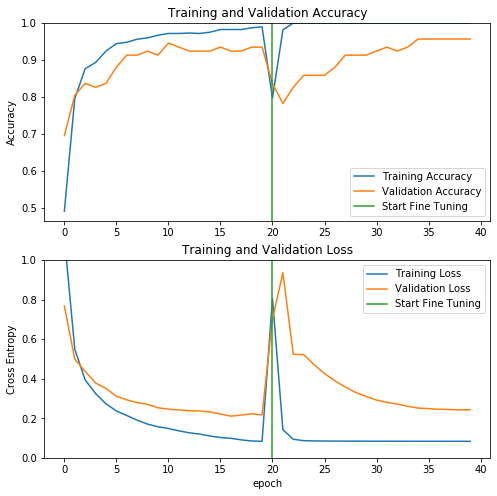

In [14]:
# Draw learning curves chart
fine_acc = batch_stats_callback.batch_acc
fine_val_acc = batch_stats_callback.batch_val_acc
fine_loss = batch_stats_callback.batch_losses
fine_val_loss = batch_stats_callback.batch_val_losses

fig4 = plt.figure(figsize=(8, 8))
ax1 = fig4.add_subplot(2, 1, 1)
ax1.plot(acc, label='Training Accuracy')
ax1.plot(val_acc, label='Validation Accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_ylim([min(plt.ylim()),1])
ax1.plot([initial_epoch,initial_epoch],
         ax1.get_ylim(), label='Start Fine Tuning')
ax1.legend(loc='lower right')
ax1.set_title('Training and Validation Accuracy')

ax2 = fig4.add_subplot(2, 1, 2)
ax2.plot(loss, label='Training Loss')
ax2.plot(val_loss, label='Validation Loss')
ax2.set_ylabel('Cross Entropy')
ax2.set_ylim([0,1.0])
ax2.plot([initial_epoch,initial_epoch],
         ax2.get_ylim(), label='Start Fine Tuning')
ax2.legend(loc='upper right')
ax2.set_title('Training and Validation Loss')
ax2.set_xlabel('epoch')

Classes: ['Hek293' 'Hela' 'Pc12']


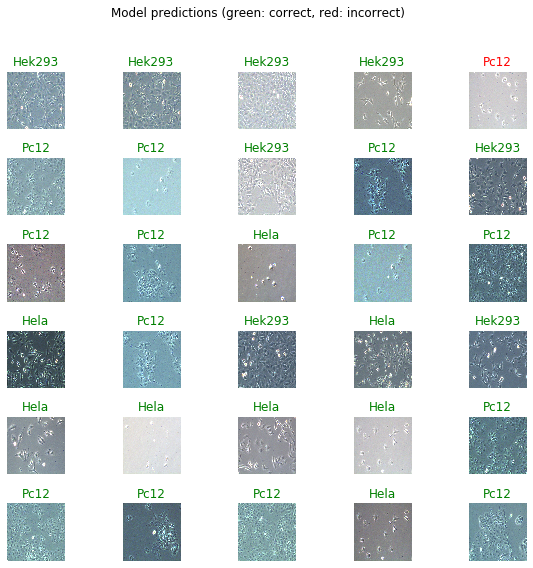

In [15]:
# Plot results
class_names = sorted(validation_data.class_indices.items(), key=lambda pair:pair[1])
class_names = np.array([key.title() for key, value in class_names])
print(f'Classes: {class_names}')

## get result labels
predicted_batch = model.predict(image_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]

label_id = np.argmax(label_batch, axis=-1)

## plot
fig5 = plt.figure(figsize=(10,9))
fig5.subplots_adjust(hspace=0.5)
for n in range(30):
    ax = fig5.add_subplot(6, 5, n+1)
    ax.imshow(image_batch[n])
    color = 'green' if predicted_id[n] == label_id[n] else 'red'
    ax.set_title(predicted_label_batch[n].title(), color=color)
    ax.axis('off')
_ = fig5.suptitle('Model predictions (green: correct, red: incorrect)')

In [16]:
# Export model too
t = time.time()

export_path = f'./saved_models/{int(t)}'
model.save(export_path, save_format='tf')

print(f'Export the model to {export_path}')

INFO:tensorflow:Assets written to: ./saved_models/1580978860/assets


INFO:tensorflow:Assets written to: ./saved_models/1580978860/assets


Export the model to ./saved_models/1580978860


In [17]:
# Check the exported model too
reloaded = tf.keras.models.load_model(export_path)

result_batch = model.predict(image_batch)
reloaded_result_batch = reloaded.predict(image_batch)

print(f'Comparison between own model and exported model {abs(reloaded_result_batch - result_batch).max()}')

Comparison between own model and exported model 0.0
